In [797]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import math
import time

Device configuration


In [798]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
print(device)

cpu


In [799]:
if torch.cuda.is_available():
    print("cuda available with GPU:", torch.cuda.get_device_name(0))

Load and prepare data<br>
Create a DataFrame from the data (you might need to adjust this based on how you load your data)


In [800]:
data_path = "./data/"

In [801]:
train_data = pd.read_csv(data_path + "rnn_train_data.csv")
data = pd.read_csv(data_path + "rnn_full_data.csv")

agg crime_count


In [802]:
train_data = (
    train_data.groupby(["Year", "Month"]).agg({"crime_count": "sum"}).reset_index()
)
data = data.groupby(["Year", "Month"]).agg({"crime_count": "sum"}).reset_index()
test_data = data[data["Year"].isin([2023, 2024])]
data

,Year,Month,crime_count
0,2020,1,19653.0
1,2020,2,18018.0
2,2020,3,16526.0
3,2020,4,12716.0
4,2020,5,17329.0
5,2020,6,17385.0
6,2020,7,19298.0
7,2020,8,19586.0
8,2020,9,17585.0
9,2020,10,18029.0


Normalize the crime count data


In [803]:
scaler = MinMaxScaler()
crime_data = scaler.fit_transform(train_data[["crime_count"]]).reshape(-1, 1)
crime_data_test = scaler.transform(test_data[["crime_count"]]).reshape(-1, 1)

Create sequences for time series data


In [804]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i : i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

Parameters


In [805]:
seq_length = 12  # Number of previous months to use for prediction
input_size = 1  # Each input is just the crime count
hidden_size = 32
num_layers = 1
batch_size = 1

Create sequences


In [806]:
X_train, y_train = create_sequences(crime_data, seq_length)
X_test, y_test = create_sequences(crime_data_test, seq_length)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((36, 12, 1), (36, 1), (12, 12, 1), (12, 1))

Convert to PyTorch tensors


In [807]:
X_train = torch.FloatTensor(X_train).to(device)
y_train = torch.FloatTensor(y_train).to(device)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)

Create batches


In [808]:
def create_batches(X, y, batch_size):
    num_batches = len(X) // batch_size
    X_batches = []
    y_batches = []
    for i in range(num_batches):
        X_batches.append(X[i * batch_size : (i + 1) * batch_size])
        y_batches.append(y[i * batch_size : (i + 1) * batch_size])
    return X_batches, y_batches

In [809]:
X_train_batches, y_train_batches = create_batches(X_train, y_train, batch_size)
X_test_batches, y_test_batches = create_batches(X_test, y_test, batch_size)
np.shape(X_train_batches), np.shape(y_train_batches), np.shape(
    X_test_batches
), np.shape(y_test_batches)

((36, 1, 12, 1), (36, 1, 1), (12, 1, 12, 1), (12, 1, 1))

In [810]:
class CrimeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers):
        super(CrimeRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layer
        self.rnn = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x, h_init):
        # Forward propagate RNN
        out, h_final = self.rnn(x, h_init)

        # Get output from the last time step
        out = self.fc(out[:, -1, :])
        return out, h_final

Initialize model


In [811]:
model = CrimeRNN(input_size, hidden_size, num_layers).to(device)

Loss and optimizer


In [812]:
criterion = nn.MSELoss()
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Train the model


In [813]:
num_epochs = 60
total_step = len(X_train_batches)

In [ ]:
for epoch in range(num_epochs):
    h_next = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    for i in range(total_step):
        # Forward pass
        h_next = h_next.detach()
        outputs, h_next = model(X_train_batches[i], h_init=h_next)
        loss = criterion(outputs, y_train_batches[i])
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [10/60], Loss: 0.0188
Epoch [20/60], Loss: 0.0146
Epoch [30/60], Loss: 0.0084
Epoch [40/60], Loss: 0.0019
Epoch [50/60], Loss: 0.0004
Epoch [60/60], Loss: 0.0007
(36, 1, 12, 1)
torch.Size([1, 1])
torch.Size([1, 1, 32])


Test the model


In [815]:
model.eval()
with torch.no_grad():
    # Test on the test set
    total_loss = 0
    h_next = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    for i in range(len(X_test_batches)):
        outputs, h_next = model(X_test_batches[i], h_next)
        loss = criterion(outputs, y_test_batches[i])
        total_loss += loss.item()
    avg_loss = total_loss / len(X_test_batches)
    print(f"Test Loss: {avg_loss:.4f}")

    # Convert predictions back to original scale
    test_predictions = []
    h_next = torch.zeros(num_layers, batch_size, hidden_size).to(device)
    for i in range(len(X_test_batches)):
        pred, h_next = model(X_test_batches[i], h_next)
        test_predictions.append(pred.cpu().numpy())
    test_predictions = np.concatenate(test_predictions, axis=0)
    test_predictions = scaler.inverse_transform(test_predictions)

    # Convert actual values back to original scale
    actual_values = []
    for i in range(len(y_test_batches)):
        actual_values.append(y_test_batches[i].cpu().numpy())
    actual_values = np.concatenate(actual_values, axis=0)
    actual_values = scaler.inverse_transform(actual_values)

    # Calculate RMSE
    rmse = np.sqrt(np.mean((test_predictions - actual_values) ** 2))
    print(f"Test RMSE: {rmse:.2f}")

Test Loss: 0.0047
Test RMSE: 786.72


Predict the next month's crime count


In [816]:
def predict_next_month(model, data, scaler, seq_length):
    # Get the last sequence from the data
    last_sequence = data[-seq_length:].reshape(1, seq_length, 1)
    last_sequence = torch.FloatTensor(last_sequence).to(device)

    # Predict
    with torch.no_grad():
        h_next = torch.zeros(num_layers, 1, hidden_size).to(device)
        model.eval()
        next_month_pred, _ = model(last_sequence, h_next)

    # Inverse transform
    next_month_pred = scaler.inverse_transform(next_month_pred.cpu().numpy())
    return next_month_pred[0][0]

Predict the next month after our dataset


In [817]:
next_month_crime = predict_next_month(model, crime_data, scaler, seq_length)
print(f"Predicted crime count for next month: {next_month_crime:.2f}")

Predicted crime count for next month: 19445.91


Visualize predictions vs actual values


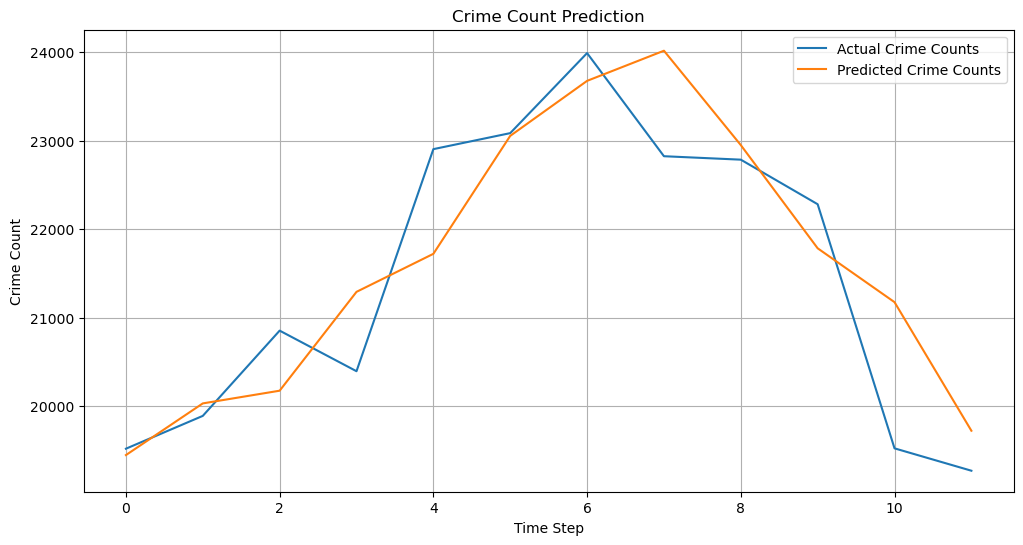

In [818]:
plt.figure(figsize=(12, 6))
plt.plot(actual_values, label="Actual Crime Counts")
plt.plot(test_predictions, label="Predicted Crime Counts")
plt.title("Crime Count Prediction")
plt.xlabel("Time Step")
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.savefig(format="pdf", fname="crime_prediction.pdf")
plt.show()